# BEE 4750 Homework 2: Dissolved Oxygen

**Name**: Anthony Nicolaides

**ID**: ajn68

> **Due Date**
>
> Friday, 09/22/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [117]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/BEE4750/hw/hw02-anthonynic28`


In [118]:
using Plots
using LaTeXStrings
using Distributions

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.35 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10 mg/L.

![Figure 1: Schematic of the
system](figures/river_diagram.png)

### Problem 1 (8 points)

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      |             100,000 L/d |             10,000 L/d |             15,000 L/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [119]:
ka = 0.55 # day^(-1); oxygen reaeration rate
kc = 0.35 # day^(-1); decay rate of CBOD
kn = 0.25 # day^(-1); decay rate of NBOD

Cs = 10 # mg/L

U = 6 # km/d

d_streams = 15 # km

Q_river = 100000 # L/d
Q_stream1 = 10000 # L/d
Q_stream2 = 15000 # L/d

DO_river = 7.5 # mg/L
DO_stream1 = 5 # mg/L
DO_stream2 = 5 # mg/L

CBOD_river = 5 # mg/L
CBOD_stream1 = 50 # mg/L
CBOD_stream2 = 45 # mg/L

NBOD_river = 5 # mg/L
NBOD_stream1 = 35 # mg/L
NBOD_stream2 = 35 # mg/L

# calculating the initial condition of box 1
C0_box1 = ((DO_river * Q_river) + (DO_stream1 * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial DO concentration
B0_box1 = ((CBOD_river * Q_river) + (CBOD_stream1 * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial CBOD concentration
N0_box1 = ((NBOD_river * Q_river) + (NBOD_stream1 * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial NBOD concentration

# calculating the initial condition of box 2 (based on the outflow of box 1 at x = 15 km)
x_box2 = d_streams
alpha_1 = exp((-ka * x_box2) / U)
alpha_2 = (kc / (ka - kc)) * (exp((-kc * x_box2) / U) - alpha_1)
alpha_3 = (kn / (ka - kn)) * (exp((-kn * x_box2) / U) - alpha_1)
DO_box2 = (Cs * (1 - alpha_1)) + (C0_box1 * alpha_1) - (B0_box1 * alpha_2) - (N0_box1 * alpha_3)
CBOD_box2 = B0_box1*exp((-kc*d_streams) / U)
NBOD_box2 = N0_box1*exp((-kn*d_streams) / U)

C0_box2 = ((DO_box2 * Q_river) + (DO_stream2 * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial DO concentration
B0_box2 = ((CBOD_box2 * Q_river) + (CBOD_stream2 * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial CBOD concentration
N0_box2 = ((NBOD_box2 * Q_river) + (NBOD_stream2 * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial NBOD concentration

function dissolved_oxygen(x, Cs, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2, N0_box2, ka, kc, kn, U, d_streams)
     if x <= d_streams
          alpha_1 = exp((-ka * x) / U)
          alpha_2 = (kc / (ka - kc)) * (exp((-kc * x) / U) - alpha_1)
          alpha_3 = (kn / (ka - kn)) * (exp((-kn * x) / U) - alpha_1)
          C = (Cs * (1 - alpha_1)) + (C0_box1 * alpha_1) - (B0_box1 * alpha_2) - (N0_box1 * alpha_3)
     elseif x > d_streams
          x = x - d_streams # Waste Steam 2 is where x = 0 is for box 2
          alpha_1 = exp((-ka * x) / U)
          alpha_2 = (kc / (ka - kc)) * (exp((-kc * x) / U) - alpha_1)
          alpha_3 = (kn / (ka - kn)) * (exp((-kn * x) / U) - alpha_1)
          C = (Cs * (1 - alpha_1)) + (C0_box2 * alpha_1) - (B0_box2 * alpha_2) - (N0_box2 * alpha_3)
     end
     return C
end

dissolved_oxygen (generic function with 1 method)

### Problem 2 (4 points)

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

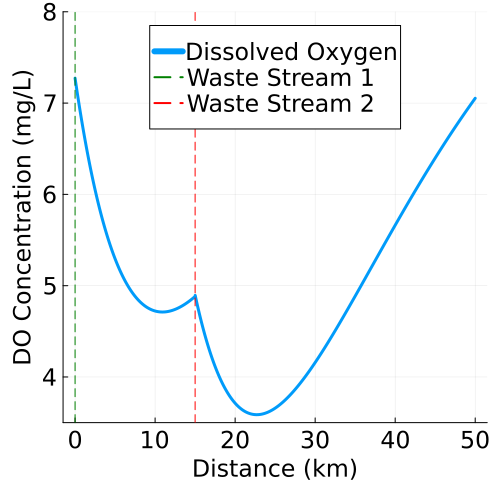

In [120]:
x_step = 0.01 # km
x_max = 50 # km
x = 0:x_step:x_max # array from 0 to x_max in stepsize x_step

C = (y -> dissolved_oxygen(y, Cs, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2, N0_box2, ka, kc, kn, U, d_streams)).(x)


plot(x, C; linewidth=3,
    label="Dissolved Oxygen",
    tickfontsize=16,
    guidefontsize=16,
    legendfontsize=16,
    legend=:top)
xlabel!("Distance (km)")
ylabel!("DO Concentration (mg/L)")
vline!([0], color=:green,
    linestyle=:dash,
    label="Waste Stream 1")
vline!([d_streams], color=:red,
    linestyle=:dash,
    label="Waste Stream 2")
plot!(size=(500, 500))
ylims!(3.5,8)

I notice uhhhhhh

### Problem 3 (3 points)

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [121]:
x0 = d_streams # km; distance where waste stream 2 is located --> start at x = 15 for the function to start at waste stream 2
x_step = 0.01 # km
y = 0
while y < 6
    y = dissolved_oxygen(x0, Cs, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2, N0_box2, ka, kc, kn, U, d_streams)
    x0 = x0 + x_step
end
DO_recovery_dist = round(x0 - x_step - d_streams, digits = 2) # find distance with waste stream 2 being at x = 0
display("$DO_recovery_dist km")

"27.24 km"

### Problem 4 (5 points)

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

In [122]:
function dCdx_function(x, Cs, ka, kc, kn, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2, N0_box2, U, d_streams)
    if x < d_streams
        dC_alpha1 = (-ka / U) * exp((-ka * x) / U)
        dC_alpha2 = (kc / (ka - kc)) * (((-kc / U) * exp((-kc * x) / U)) - dC_alpha1)
        dC_alpha3 = (kn / (ka - kn)) * (((-kn / U) * exp((-kn * x) / U)) - dC_alpha1)
        dC = (-Cs * dC_alpha1) + (C0_box1 * dC_alpha1) - (B0_box1 * dC_alpha2) - (N0_box1 * dC_alpha3)
    elseif x >= d_streams
        x = x - d_streams
        dC_alpha1 = (-ka / U) * exp((-ka * x) / U)
        dC_alpha2 = (kc / (ka - kc)) * (((-kc / U) * exp((-kc * x) / U)) - dC_alpha1)
        dC_alpha3 = (kn / (ka - kn)) * (((-kn / U) * exp((-kn * x) / U)) - dC_alpha1)
        dC = (-Cs * dC_alpha1) + (C0_box2 * dC_alpha1) - (B0_box2 * dC_alpha2) - (N0_box2 * dC_alpha3)
    end
    return dC
end

dCdx_function (generic function with 2 methods)

In [123]:
treatment_level = 0
x = d_streams
x_step = 0.01
min_DO = 0
regulation_standard = 4 # mg/L
while treatment_level <= 1
    B0_box2_treated = ((CBOD_box2 * Q_river) + (CBOD_stream2 * (1 - treatment_level) * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial CBOD concentration
    N0_box2_treated = ((NBOD_box2 * Q_river) + (NBOD_stream2 * (1 - treatment_level) * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial NBOD concentration
    slope = dCdx_function(x, Cs, ka, kc, kn, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2_treated, N0_box2_treated, U, d_streams)
    while slope < 0
        slope = dCdx_function(x, Cs, ka, kc, kn, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2_treated, N0_box2_treated, U, d_streams)
        x = x + x_step
    end
    x = x - x_step
    min_DO = dissolved_oxygen(x, Cs, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2_treated, N0_box2_treated, ka, kc, kn, U, d_streams)
    if min_DO >= regulation_standard
        break
    end
    treatment_level = treatment_level + 0.01
    x = d_streams
end
min_DO = round(min_DO, digits=3)
percentage_treatment_level_plan1 = round(100 * treatment_level, digits=2)
display("$percentage_treatment_level_plan1% is the minimum treatment level that results in a minimum DO concentration of $min_DO mg/L")

"18.0% is the minimum treatment level that results in a minimum DO concentration of 4.001 mg/L"

### Problem 5 (5 points)

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

In [165]:
treatment_level = 0
x = 0
x_step = 0.01
min_DO_box1 = 0
min_DO_box2 = 0
regulation_standard = 4 # mg/L
while treatment_level <= 1
    B0_box1_treated = ((CBOD_river * Q_river) + (CBOD_stream1 * (1 - treatment_level) * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial CBOD concentration
    N0_box1_treated = ((NBOD_river * Q_river) + (NBOD_stream1 * (1 - treatment_level) * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial NBOD concentration
    slope_box1 = dCdx_function(x, Cs, ka, kc, kn, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2, N0_box2, U, d_streams)
    while  slope_box1 < 0
        slope_box1 = dCdx_function(x, Cs, ka, kc, kn, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2, N0_box2, U, d_streams)
        x = x + x_step
    end
    x_box1 = x - x_step
    min_DO_box1 = dissolved_oxygen(x, Cs, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2, N0_box2, ka, kc, kn, U, d_streams)

    B0_box2_treated = ((CBOD_box2 * Q_river) + (CBOD_stream2 * (1 - treatment_level) * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial CBOD concentration
    N0_box2_treated = ((NBOD_box2 * Q_river) + (NBOD_stream2 * (1 - treatment_level) * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial NBOD concentration
    slope_box2 = dCdx_function(x+d_streams, Cs, ka, kc, kn, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2_treated, N0_box2_treated, U, d_streams)
    while  slope_box2 < 0
        slope_box2 = dCdx_function(x+d_streams, Cs, ka, kc, kn, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2_treated, N0_box2_treated, U, d_streams)
        x = x + x_step
    end
    x_box2 = x - x_step
    min_DO_box2 = dissolved_oxygen(x+d_streams, Cs, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2_treated, N0_box2_treated, ka, kc, kn, U, d_streams)
    if (min_DO_box1 >= regulation_standard) && (min_DO_box2 >= regulation_standard)
        break
    end
    treatment_level = treatment_level + 0.01
    x = 0
end
min_DO_box1 = round(min_DO_box1, digits=3)
min_DO_box2 = round(min_DO_box2, digits=3)
percentage_treatment_level_plan2 = round(100*treatment_level, digits=2)
display("$percentage_treatment_level_plan2% is the minimum treatment level that results in a minimum DO concentration of $min_DO_box1 mg/L for stream 1 and $min_DO_box2 mg/L for stream 2")

"11.0% is the minimum treatment level that results in a minimum DO concentration of 5.095 mg/L for stream 1 and 4.002 mg/L for stream 2"

### Problem 6 (5 points)

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

In [125]:
for DO_river = 6:0.5:8
C0_box1 = ((DO_river * Q_river) + (DO_stream1 * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial DO concentration
treatment_level = 0
x = 0
x_step = 0.01
min_DO_box1 = 0
min_DO_box2 = 0
regulation_standard = 4 # mg/L
while treatment_level <= 1
    B0_box1_treated = ((CBOD_river * Q_river) + (CBOD_stream1 * (1 - treatment_level) * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial CBOD concentration
    N0_box1_treated = ((NBOD_river * Q_river) + (NBOD_stream1 * (1 - treatment_level) * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial NBOD concentration
    slope_box1 = dCdx_function(x, Cs, ka, kc, kn, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2, N0_box2, U, d_streams)
    while  slope_box1 < 0
        slope_box1 = dCdx_function(x, Cs, ka, kc, kn, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2, N0_box2, U, d_streams)
        x = x + x_step
    end
    x_box1 = x - x_step
    min_DO_box1 = dissolved_oxygen(x, Cs, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2, N0_box2, ka, kc, kn, U, d_streams)

    B0_box2_treated = ((CBOD_box2 * Q_river) + (CBOD_stream2 * (1 - treatment_level) * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial CBOD concentration
    N0_box2_treated = ((NBOD_box2 * Q_river) + (NBOD_stream2 * (1 - treatment_level) * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial NBOD concentration
    slope_box2 = dCdx_function(x+d_streams, Cs, ka, kc, kn, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2_treated, N0_box2_treated, U, d_streams)
    while  slope_box2 < 0
        slope_box2 = dCdx_function(x+d_streams, Cs, ka, kc, kn, C0_box1, B0_box1_treated, N0_box1_treated, C0_box2, B0_box2_treated, N0_box2_treated, U, d_streams)
        x = x + x_step
    end
    x_box2 = x - x_step
    min_DO_box2 = dissolved_oxygen(x+d_streams, Cs, C0_box1, B0_box1, N0_box1, C0_box2, B0_box2_treated, N0_box2_treated, ka, kc, kn, U, d_streams)
    if (min_DO_box1 >= regulation_standard) && (min_DO_box2 >= regulation_standard)
        break
    end
    treatment_level = treatment_level + 0.01
    x = 0
end
min_DO_box1 = round(min_DO_box1, digits=3)
min_DO_box2 = round(min_DO_box2, digits=3)
percentage_treatment_level = round(100*treatment_level, digits=2)
display("$percentage_treatment_level% is the minimum treatment level that results in a minimum DO concentration of $min_DO_box1 mg/L for stream 1 and $min_DO_box2 mg/L for stream 2")
end

"17.0% is the minimum treatment level that results in a minimum DO concentration of 4.481 mg/L for stream 1 and 4.016 mg/L for stream 2"

"15.0% is the minimum treatment level that results in a minimum DO concentration of 4.645 mg/L for stream 1 and 4.005 mg/L for stream 2"

"13.0% is the minimum treatment level that results in a minimum DO concentration of 4.794 mg/L for stream 1 and 4.0 mg/L for stream 2"

"11.0% is the minimum treatment level that results in a minimum DO concentration of 4.93 mg/L for stream 1 and 4.001 mg/L for stream 2"

"9.0% is the minimum treatment level that results in a minimum DO concentration of 5.055 mg/L for stream 1 and 4.004 mg/L for stream 2"

### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5000
L</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

In [139]:
function dissolved_oxygen_stream3(x, Cs, C0_box3, B0_box3, N0_box3, ka, kc, kn, U, D)
    x = x - D
    alpha_1 = exp((-ka * x) / U)
    alpha_2 = (kc / (ka - kc)) * (exp((-kc * x) / U) - alpha_1)
    alpha_3 = (kn / (ka - kn)) * (exp((-kn * x) / U) - alpha_1)
    C = (Cs * (1 - alpha_1)) + (C0_box3 * alpha_1) - (B0_box3 * alpha_2) - (N0_box3 * alpha_3)
    return C
end

function dCdx_function_stream3(x, Cs, ka, kc, kn, C0_box3, B0_box3, N0_box3, U, D)
    x = x - D
    dC_alpha1 = (-ka / U) * exp((-ka * x) / U)
    dC_alpha2 = (kc / (ka - kc)) * (((-kc / U) * exp((-kc * x) / U)) - dC_alpha1)
    dC_alpha3 = (kn / (ka - kn)) * (((-kn / U) * exp((-kn * x) / U)) - dC_alpha1)
    dC = (-Cs * dC_alpha1) + (C0_box3 * dC_alpha1) - (B0_box3 * dC_alpha2) - (N0_box3 * dC_alpha3)
    return dC
end

dCdx_function_stream3 (generic function with 2 methods)

In [164]:
Q_stream3 = 5000 # L/d
DO_stream3 = 4.5 # mg/L
CBOD_stream3 = 50 # mg/L
NBOD_stream3 = 45 # mg/L

treatment_level_plan2 = percentage_treatment_level_plan2 / 100
B0_box1_treated = ((CBOD_river * Q_river) + (CBOD_stream1 * (1 - treatment_level_plan2) * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial CBOD concentration
N0_box1_treated = ((NBOD_river * Q_river) + (NBOD_stream1 * (1 - treatment_level_plan2) * Q_stream1)) / (Q_river + Q_stream1) # mg/L; initial NBOD concentration

B0_box2_treated = ((CBOD_box2 * Q_river) + (CBOD_stream2 * (1 - treatment_level_plan2) * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial CBOD concentration
N0_box2_treated = ((NBOD_box2 * Q_river) + (NBOD_stream2 * (1 - treatment_level_plan2) * Q_stream2)) / (Q_river + Q_stream2) # mg/L; initial NBOD concentration

D = 0 # km
D_step = 0.1 # km
D_x_step = 0.01
min_DO_box3 = 0
regulation_standard = 4 # mg/L
while min_DO_box3 < regulation_standard
    # calculating the initial condition of box 3 (based on the outflow of box 2 at x = D km)
    x_box3 = D
    alpha_1 = exp((-ka * x_box3) / U)
    alpha_2 = (kc / (ka - kc)) * (exp((-kc * x_box3) / U) - alpha_1)
    alpha_3 = (kn / (ka - kn)) * (exp((-kn * x_box3) / U) - alpha_1)
    DO_box3 = (Cs * (1 - alpha_1)) + (C0_box2 * alpha_1) - (B0_box2 * alpha_2) - (N0_box2 * alpha_3)
    CBOD_box3 = B0_box2 * exp((-kc * D) / U)
    NBOD_box3 = N0_box2 * exp((-kn * D) / U)

    C0_box3 = ((DO_box3 * Q_river) + (DO_stream3 * Q_stream3)) / (Q_river + Q_stream3) # mg/L; initial DO concentration
    B0_box3 = ((CBOD_box3 * Q_river) + (CBOD_stream3 * Q_stream3)) / (Q_river + Q_stream3) # mg/L; initial CBOD concentration
    N0_box3 = ((NBOD_box3 * Q_river) + (NBOD_stream3 * Q_stream3)) / (Q_river + Q_stream3) # mg/L; initial NBOD concentration

    slope_box3 = dCdx_function_stream3(D, Cs, ka, kc, kn, C0_box3, B0_box3, N0_box3, U, D)
    D_x = D
    while slope_box3 < 0
        slope_box3 = dCdx_function_stream3(D_x, Cs, ka, kc, kn, C0_box3, B0_box3, N0_box3, U, D)
        D_x = D_x + D_x_step
    end
    x_box3 = D_x - D_x_step
    min_DO_box3 = dissolved_oxygen_stream3(x_box3, Cs, C0_box3, B0_box3, N0_box3, ka, kc, kn, U, D)
    if min_DO_box3 >= regulation_standard
        break
    end
    D = D + D_step
end
min_DO_box3 = round(min_DO_box3, digits = 3)
min_distance_from_stream2 = round(D, digits = 2)
print("Under the Problem 5 treatment plan, $min_distance_from_stream2 km is the minimum distance stream 3 can be from stream 2
    that results in a minimum DO concentration of $min_DO_box3 mg/L for stream 3")

Under the Problem 5 treatment plan, 14.4 km is the minimum distance stream 3 can be from stream 2
    that results in a minimum DO concentration of 4.0 mg/L for stream 3

## References

List any external references consulted, including classmates.

I used some code from lecture